## Vehicle Detection Project

In [1]:
# Pipeline for Project 5
# 1. Extract Features from images
# 2. Train Classifier
# 3. Sliding window to make detections in images

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pdb
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
import time
import math
%matplotlib inline
test_mode = True

/Users/Akshay/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Method for printing images
def print_image(img, title = ""):
    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.title(title)
    
def print_gray_image(img, title = ""):
    plt.figure(figsize=(7, 7))
    plt.imshow(img, cmap="gray")
    plt.title(title)

In [3]:
# Read in our vehicles and non-vehicles
cars = glob.glob('/Users/Akshay/projects/carnd/CarND-Vehicle-Detection/feature_extraction_data/vehicles/*.jpeg')
notcars = glob.glob('/Users/Akshay/projects/carnd/CarND-Vehicle-Detection/feature_extraction_data/non-vehicles/*.jpeg')
test_images = glob.glob('/Users/Akshay/projects/carnd/CarND-Vehicle-Detection/test_images/*.jpg')

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, 
                     cspace='RGB', 
                     orient=9, 
                     pix_per_cell=8, 
                     cell_per_block=2,
                     hog_channel=0,
                     spatial_size=(32, 32),
                     hist_bins=32, 
                     hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        spatial_features = bin_spatial(feature_image, size = spatial_size)
        hist_features = color_hist(feature_image, nbins = hist_bins, bins_range = hist_range)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

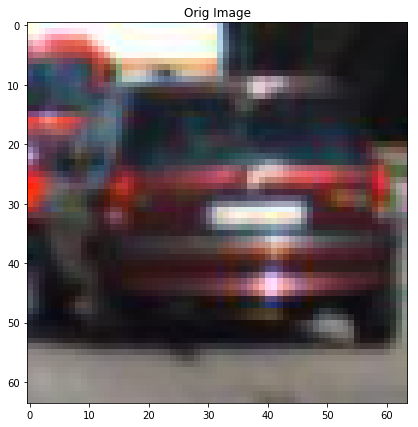

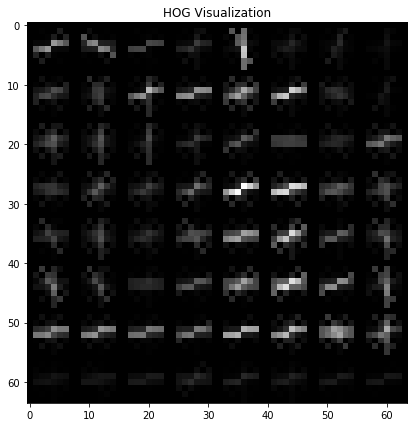

In [8]:
if test_mode:
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(cars))
    image = mpimg.imread(cars[ind])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Call our function with vis=True to see an image output
    hog_features, hog_image = get_hog_features(gray,
                                               orient,
                                               pix_per_cell,
                                               cell_per_block,
                                               vis=True,
                                               feature_vec=False)

    print_image(image, 'Orig Image')
    print_gray_image(hog_image, 'HOG Visualization')

In [9]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 16

t = time.time()
car_features = extract_features(cars, 
                                cspace = colorspace, 
                                orient = orient, 
                                pix_per_cell = pix_per_cell, 
                                cell_per_block = cell_per_block, 
                                hog_channel = hog_channel,
                                spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256))

notcar_features = extract_features(notcars, 
                                   cspace = colorspace, 
                                   orient = orient, 
                                   pix_per_cell = pix_per_cell, 
                                   cell_per_block = cell_per_block, 
                                   hog_channel = hog_channel,
                                   spatial_size=(spatial, spatial),
                                   hist_bins=histbin, hist_range=(0, 256))

t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector. 1 if car present and 0 if not
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

15.74 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8412
0.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9957
My SVC predicts:  [ 1.  1.  0.  0.  0.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  1.  0.  0.  0.  1.]
0.003 Seconds to predict 10 labels with SVC


In [10]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, 
                 x_start_stop=[None, None], 
                 y_start_stop=[None, None], 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):

    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, 
                        color_space='RGB', 
                        spatial_size=(32, 32),
                        hist_bins=32, 
                        orient=9, 
                        pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel=0,
                        spatial_feat=True, 
                        hist_feat=True, 
                        hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [11]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [12]:
previous_heatmaps = []

def add_heat(heatmap, bbox_list):
    global previous_heatmaps
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    if len(bbox_list) > 0:
        previous_heatmaps += [heatmap]
        
    for hm in previous_heatmaps[-30:]:
        heatmap[hm == 1] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def uniform_box_size(bbox):
    min_side_len = 64
    x1 = bbox[0][0]
    y1 = bbox[0][1]
    x2 = bbox[1][0]
    y2 = bbox[1][1]
    
    if (x2 - x1) < min_side_len:
        expand_size = int((x2 - x1) / 2) + 10
        x1 -= expand_size
        x2 += expand_size
        
    if (y2 - y1) < min_side_len:
        expand_size = int((y2 - y1) / 2)
        y1 -= expand_size
        y2 += expand_size
        
    return ((x1, y1), (x2, y2))
    
def draw_labeled_bboxes(img, labels):
    boxes_to_draw = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox = uniform_box_size(bbox)
        boxes_to_draw.append(bbox)
        
    boxes_to_draw = get_qualifying_bboxes(boxes_to_draw)

    for bbox in boxes_to_draw:
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    # Return the image
    return img

In [ ]:
# Weed out false positives
N = 3
last_n_frames = []
distance_threshold = 20 # pixels

def get_qualifying_bboxes(bboxes):
    global last_n_frames
    selected_boxes = []
    
    for box in bboxes:
        if qualifies_for_inclusion(box):
            selected_boxes.append(box)
    
    last_n_frames.append(selected_boxes)
    
    return selected_boxes
    
def qualifies_for_inclusion(box):
    count = 0
    
    for frame_boxes in last_n_frames[-N:]:
        for frame_box in frame_boxes:
            if(get_distance(box, frame_box) < distance_threshold):
                count += 1

    if count == N:
        print("Including")
        return True

    return False

def get_distance(box1, box2):
    centroid1 = get_centroid(box1)
    centroid2 = get_centroid(box2)
    d = (centroid2[0] - centroid1[0])**2 + (centroid2[1] - centroid1[1])**2
    return int(math.sqrt(d))

def get_centroid(box1):
    (int((box1[0] - box1[0]) / 2), int((box1[1][1] - box1[0][1]) / 2))

In [ ]:
y_start_stop = [384, 640]
x_start_stop = [672, None]

def detect_and_draw(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    draw_image = np.copy(image)
    draw_image = np.copy(image)
    all_windows = []
    for scale_mult in [2, 2.5, 3]:
        windows = slide_window(image, 
                           x_start_stop = x_start_stop, 
                           y_start_stop = y_start_stop, 
                           xy_window=(int(32* scale_mult), int(32 * scale_mult)),
                           xy_overlap=(0.85, 0.85))
        
        if test_mode:
            window_img = draw_boxes(draw_image, windows, color=(255, 0, 0), thick = 6)
            print_image(window_img)
        
        all_windows += windows

    hot_windows = search_windows(image, 
                                 all_windows, 
                                 svc, 
                                 X_scaler, 
                                 color_space = colorspace, 
                                 spatial_size = (spatial, spatial), 
                                 hist_bins = histbin, 
                                 orient = orient, 
                                 pix_per_cell = pix_per_cell, 
                                 cell_per_block = cell_per_block, 
                                 hog_channel = hog_channel, 
                                 spatial_feat = True, 
                                 hist_feat = True, 
                                 hog_feat = True)                       

    heat = add_heat(heat, hot_windows)
    
    if test_mode:
            print_image(heat)
    
    heat = apply_threshold(heat, 8)
    heatmap = np.clip(heat, 0, 255)
    
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if test_mode:
            window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick = 4)
            print_image(window_img)
            
    return draw_img

test_mode = True
if test_mode == True:
    for image in test_images:
        print("Running pipeline on image")
        image = mpimg.imread(image)
        window_img = detect_and_draw(image)
        print_image(window_img)

Running pipeline on image
> <ipython-input-13-339811681d3d>(9)get_qualifying_bboxes()
-> selected_boxes = []
(Pdb) c
> <ipython-input-13-339811681d3d>(16)get_qualifying_bboxes()
-> last_n_frames.append(selected_boxes)
(Pdb) c
Running pipeline on image


In [ ]:
if not test_mode:
    output = './p5.mp4'
    clip1 = VideoFileClip("project_video.mp4").subclip(22, 24)
    white_clip = clip1.fl_image(detect_and_draw) # NOTE: this function expects color images!!
    %time white_clip.write_videofile(output, audio=False)